In [1]:
from shapely.geometry import box, Point, Polygon, LineString, MultiLineString
from shapely.affinity import scale
from shapely.ops import unary_union
import pickle

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import pdb

# Definitions

In [2]:
class Building:
    def __init__(self, building_type, door, city, p_still, sigma, blocks=None, bbox=None):
        self.building_type = building_type
        self.door = door
        self.city = city

        self.p_still = p_still
        self.sigma = sigma

        # Calculate the bounding box of the building
        if blocks:
            min_x = min([block[0] for block in blocks])
            min_y = min([block[1] for block in blocks])
            max_x = max([block[0]+1 for block in blocks])
            max_y = max([block[1]+1 for block in blocks])
            bbox = box(min_x, min_y, max_x, max_y)
        elif bbox:
            blocks = []
            for x in range(int(bbox.bounds[0]), int(bbox.bounds[2])):
                for y in range(int(bbox.bounds[1]), int(bbox.bounds[3])):
                    blocks += [(x, y)]
        else:
            raise ValueError(
                "Either blocks spanned or bounding box must be provided."
            )

        self.blocks = blocks
        self.geometry = bbox

        # Compute door centroid
        door = self.geometry.intersection(self.city.streets[self.door].geometry)
        self.door_centroid = ((door.coords[0][0] + door.coords[1][0]) / 2,
                              (door.coords[0][1] + door.coords[1][1]) / 2)

    def get_id(self):
        return (self.door, self.building_type)


class Street:
    def __init__(self, coordinates):
        self.coordinates = coordinates
        self.neighbors_streets = []
        self.neighbors_buildings = []
        self.geometry = box(coordinates[0], coordinates[1],
                            coordinates[0]+1, coordinates[1]+1)

    def add_neighbor(self, neighbor):
        if neighbor is None or not check_adjacent(self.geometry, neighbor.geometry):
            return False
        if isinstance(neighbor, Street):
            self.neighbors_streets.append(neighbor)
            return True
        if isinstance(neighbor, Building) and neighbor.door == self.coordinates:
            self.neighbors_buildings.append(neighbor)
            return True
        return False


class City:
    def __init__(self, dimensions=(0, 0)):
        self.buildings = {}
        self.streets = {}
        self.buildings_outline = Polygon()
        self.address_book = {}

        # maybe at some point, p_still and sigma are inputs rather than hard coded
        self.p_still = {'park': 0.1,
                        'home': 0.6,
                        'work': 0.9,
                        'retail': 0.2}

        # controls "speed" of Brownian motion when simulating stay trajectory
        # The random variable X(t) of the position at time t has a normal
        # distribution with mean 0 and variance sigma^2 * t.
        # x/1.96 = 95% probability of moving x standard deviations
        self.sigma = {'park': 3/1.96,
                      'home': 1/1.96,
                      'work': 1/1.96,
                      'retail': 2/1.96}

        if not (isinstance(dimensions, tuple) and len(dimensions) == 2
                and all(isinstance(d, int) for d in dimensions)):
            raise ValueError("Dimensions must be a tuple of two integers.")
        self.city_boundary = box(0, 0, dimensions[0], dimensions[1])

        for x in range(0, dimensions[0]):
            for y in range(0, dimensions[1]):
                self.streets[(x, y)] = Street((x, y))
        self.dimensions = dimensions

    def add_building(self, building_type, door, blocks=None, bbox=None):
        building = Building(building_type, door, self,
                            self.p_still[building_type],
                            self.sigma[building_type],
                            blocks, bbox)

        combined_plot = unary_union([building.geometry, self.streets[door].geometry])
        if self.buildings_outline.contains(combined_plot) or self.buildings_outline.overlaps(combined_plot):
            raise ValueError(
                "New building or its door overlap with existing buildings."
            )

        if not check_adjacent(building.geometry, self.streets[door].geometry):
            raise ValueError(f"Door {door} must be adjacent to new building.")

        # add building
        self.buildings[(door, building_type)] = building
        self.buildings_outline = unary_union([self.buildings_outline, building.geometry])

        # blocks are no longer streets
        for block in building.blocks:
            self.address_book[block] = building
            del self.streets[block]

        # expand city boundary?
        buffered_building_geom = building.geometry.buffer(1)
        if not self.city_boundary.contains(buffered_building_geom):
            new_boundary = self.city_boundary.union(buffered_building_geom).envelope
            self.city_boundary = new_boundary
            self.dimensions = (int(new_boundary.bounds[2]), int(new_boundary.bounds[3]))
            # Update the streets for any new blocks within the expanded boundary
            minx, miny, maxx, maxy = map(int, new_boundary.bounds)
            for x in range(minx, maxx+1):
                for y in range(miny, maxy+1):
                    if (x, y) not in self.streets:
                        # Initialize new Street objects for the expanded city area
                        self.streets[(x, y)] = Street((x, y))

    def get_block(self, coordinates):
        # Return None if coordinates are outside the city
        x, y = coordinates
        bx, by = self.dimensions
        if (x < 0 or x >= bx or y < 0 or y >= bx):
            return None

        if coordinates in self.address_book:
            return self.address_book[coordinates]
        else:
            return self.streets[coordinates]

    # Determine adjacent streets and buildings for each street block and construct graph
    def get_street_graph(self):
        for x, y in self.streets.keys():
            street = self.streets[(x, y)]
            neighbors = [
                (x, y + 1),
                (x, y - 1),
                (x + 1, y),
                (x - 1, y)
            ]

            for neighbor in neighbors:
                block = city.get_block(neighbor)
                street.add_neighbor(block)

        # Construct graph of streets
        self.street_graph = {block: [] for block in self.streets.keys()}
        for street in self.street_graph.keys():
            self.street_graph[street] = [neighbor.coordinates for neighbor in
                                         self.get_block(street).neighbors_streets]

        # Compute shortest path between every pair of street coordinates
        self.shortest_paths = {street: {} for street in self.streets.keys()}
        for s_from in self.shortest_paths.keys():
            self.shortest_paths[s_from] = {street: [] for street in self.streets.keys()}
            for s_to in self.shortest_paths[s_from].keys():
                path = BFS_shortest_path(graph=self.street_graph, start=s_from, end=s_to)
                self.shortest_paths[s_from][s_to] = path

    def save(self, filename):
        """Save the city object to a file."""
        with open(filename, 'wb') as file:
            pickle.dump(self, file)

    def plot_city(self, ax, doors=True, address=True, zorder=1):
        # Draw city boundary
        x, y = self.city_boundary.exterior.xy
        ax.plot(np.array(x), np.array(y), linewidth=2, color='black')  # Dashed line for the boundary

        # Define colors for different building types
        colors = {
            'home': 'skyblue',
            'work': '#C9A0DC',
            'retail': 'lightgrey',
            'park': 'lightgreen'
        }

        # Draw buildings
        for building in self.buildings.values():
            x, y = building.geometry.exterior.xy
            ax.fill(x, y, facecolor=colors[building.building_type],
                    edgecolor='black', linewidth=0.5,
                    label=building.building_type.capitalize(), zorder=zorder)

            # Plot doors
            if doors:
                door_line = building.geometry.intersection(self.streets[building.door].geometry)
                scaled_door_line = scale(door_line, xfact=0.25, yfact=0.25, origin=door_line.centroid)
                dx, dy = scaled_door_line.xy
                ax.plot(dx, dy, linewidth=2, color='white', zorder=zorder)

            if address:
                door_coord = building.door

                bbox = ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())
                axes_width_in_inches = bbox.width
                axes_data_range = ax.get_xlim()[1] - ax.get_xlim()[0]
                fontsize = (axes_width_in_inches / axes_data_range) * 13  # Example scaling factor

                ax.text(door_coord[0] + 0.15, door_coord[1] + 0.15,
                        f"{door_coord[0]}, {door_coord[1]}",
                        ha='left', va='bottom',
                        fontsize=fontsize, color='black')

        ax.set_aspect('equal')
        # Set integer ticks
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))


def load(filename):
    """Load a city object from a file."""
    with open(filename, 'rb') as file:
        return pickle.load(file)


def save(city, filename):
    """Save the city object to a file."""
    with open(filename, 'wb') as file:
        pickle.dump(city, file)


def check_adjacent(geom1, geom2):
    intersection = geom1.intersection(geom2)
    return isinstance(intersection, (LineString, MultiLineString))


def BFS_shortest_path(graph, start, end):
    """
    Computes the shortest path between a start and end street block.

    Parameters
    ---------
    graph: dict
        undirected graph with streets as vectices and edges between adjacent streets
    start: tuple
        coordinates of starting street (i.e., door of start building)
    end: tuple
        coordinates of ending street (i.e., door of end building)

    Returns
    -------
    A list denoting the shortest path of street blocks going from the start to the end.
    """
    
    # is this the most efficient way to do this? could do full bfs from each start to
    # get all paths originating from that start

    explored = []
    queue = [[start]]

    if start == end:
        return [start]

    while queue:
        path = queue.pop(0)
        node = path[-1]

        if node not in explored:
            neighbors = graph[node]

            for neighbor in neighbors:
                new_path = list(path)
                new_path.append(neighbor)
                queue.append(new_path)

                if neighbor == end:
                    return new_path
            explored.append(node)

    print("Path does not exist.")
    return None

In [100]:
def sample_step(start_point, city, dest_building, dt=1):
    """
    TO DO

    Parameters
    ---------
    start_point: tuple
        the coordinates of the current position
    city: City
        the city in which to generate the trajectory step
    dest_building: Building.
        the destination building of the agent
    dt: float
        time step (i.e., number of minutes per ping)

    Returns
    -------
    coord: numpy array of floats with shape (1,2).
    location: building id if step is a stay or None is step is a move
    """
    #city = self.city

    # Find current building
    block = np.floor(start_point)  # blocks are indexed by bottom left
    start_geometry = city.get_block(tuple(block))

    curr = np.array(start_point)

    # Agent moves within the building
    if start_geometry == dest_building or start_point == dest_building.door_centroid:
        location = dest_building.get_id()
        bbox = dest_building.geometry  # building boundaries
        p = dest_building.p_still      # probability of staying still
        sigma = dest_building.sigma    # "speed" of Brownian motion

        stay_still = np.random.binomial(1, p, 1)
        if stay_still == 1:
            coord = curr
        else:
            draw = True
            # Draw until coord falls inside building
            while draw:
                coord = np.random.normal(loc=curr, scale=sigma*np.sqrt(dt), size=2)
                draw = not bbox.contains(Point(coord))

    # Agent travels to building along the streets
    else:
        location = None
        end = dest_building.door

        if start_geometry in city.buildings.values():
            start_segment = [start_point, start_geometry.door_centroid]
            start = start_geometry.door
        else:
            start_segment = []
            start = tuple(block.astype(int))

        street_path = city.shortest_paths[start][end]
        path = [(x+0.5, y+0.5) for x,y in street_path]
        path = start_segment + path + [dest_building.door_centroid]
        path_ml = MultiLineString([path])

        # Bounding polygon
        street_poly = unary_union([city.get_block(block).geometry for block in street_path])
        bbox = unary_union([start_geometry.geometry, street_poly, dest_building.geometry])

        # Snap to path
        snap_point = path_ml.project(Point(start_point))

        delta = 3.33      # 50m/s; blocks are 15m x 15m
        sigma = 0.5/1.96  # 95% prob of moving 0.5 standard deviations
        dt = 1            # time step (1 ping/min)

        if snap_point+delta >= path_ml.length:
            coord = np.array(dest_building.door_centroid)

        else:
            # Drift delta forward on path_ml
            mu = np.array(
                path_ml.interpolate(snap_point+delta, normalized=False).coords[0])

            # Draw until coord falls inside rectangle
            draw = True
            while draw:
                coord = np.random.normal(loc=mu, scale=sigma*np.sqrt(dt), size=2)
                deviation = np.linalg.norm(coord - mu, ord=np.inf)
                draw = deviation > 0.5 or not bbox.contains(Point(coord))

    return coord, location


def traj_from_dest(agent, city, seed=None, dt=1):
    """
    Simulate a trajectory and calculate true travel diary.

    Parameters
    ----------
    agent: Agent
    seed : int
        The seed for random number generation.

    Returns
    -------
    None (updates agent.trajectory, agent.diary)
    """

    if seed:
        npr.seed(seed)
    else:
        seed = npr.randint(0, 1000, 1)[0]
        npr.seed(seed)
        print("Seed:", seed)

    destination_diary = agent.destination_diary
    for i in range(destination_diary.shape[0]):
        destination_info = destination_diary.iloc[i]
        duration = destination_info['duration']
        building_id = destination_info['location']
        for t in range(duration):
            prev_ping = agent.trajectory.iloc[-1]

            start_point = (prev_ping['x'], prev_ping['y'])
            dest_building = city.buildings[building_id]
            coord, location = sample_step(start_point, city, dest_building, dt=dt)

            unix_timestamp = prev_ping['unix_timestamp'] + 60*dt
            local_timestamp = pd.to_datetime(unix_timestamp, unit='s')
            ping = {'x': coord[0], 'y': coord[1],
                    'local_timestamp': local_timestamp,
                    'unix_timestamp': unix_timestamp,
                    'identifier': agent.identifier}
            ping = pd.DataFrame([ping])
            agent.trajectory = pd.concat([agent.trajectory, ping],
                                         ignore_index=True)

            if agent.diary.empty or agent.diary.iloc[-1]['location'] != location:
                entry = {'unix_timestamp': unix_timestamp,
                         'local_timestamp': local_timestamp,
                         'duration': 1,
                         'location': location}
                entry = pd.DataFrame([entry])
                agent.diary = pd.concat([agent.diary, entry],
                                        ignore_index=True)
            else:
                agent.diary.loc[agent.diary.shape[0]-1, 'duration'] += 1*dt

     # agent.destination_diary = empty ?

In [99]:
from matplotlib import cm

class Agent:
    def __init__(self, identifier, home, workplace, destination_diary=None, transitions=None, trajectory = None, diary = None):
        """
        Parameters
        ---------
        trajectory: pandas.DataFrame
            dataframe with columns 'x', 'y', 'local_timestamp', 'unix_timestamp', 'identifier'
        destination_diary: pandas.DataFrame
            dataframe with columns 'unix_timestamp', 'local_timestamp', 'duration', 'location'
        """
        self.identifier = identifier
        self.home = home
        self.workplace = workplace
        self.destination_diary = destination_diary

        if trajectory is None:
            start_coords = home.door_centroid
            unix_timestamp = destination_diary['unix_timestamp'].iloc[0]
            local_timestamp = pd.to_datetime(unix_timestamp, unit='s')
            identifier = self.identifier
            row = [[start_coords[0], start_coords[1], local_timestamp, unix_timestamp, identifier]]
            columns = ['x', 'y', 'local_timestamp', 'unix_timestamp', 'identifier']
            self.trajectory = pd.DataFrame(row, columns=columns)
        else:
            self.trajectory = trajectory

        if not diary:
            self.diary = pd.DataFrame(
                columns=['unix_timestamp', 'local_timestamp', 'duration', 'location'])
        else:
            self.diary = diary

    def diary_from_traj(self):
        """
        TO DO
        """
        return None


class Population:
    def __init__(self, city):
        self.roster = []
        self.city = city

    def add_agent(self, agent):
        self.roster += [agent]

    def sample_step(start_point, dest_building, dt=1):
        """
        TO DO

        Parameters
        ---------
        start_point: tuple
            the coordinates of the current position
        city: City
            the city in which to generate the trajectory step
        dest_building: Building 
            the destination building of the agent
        dt: float
            time step (i.e., number of minutes per ping)

        Returns
        -------
        A numpy array of floats with shape (1,2).
        """
        city = self.city

        # Find current building
        block = np.floor(start_point)  # blocks are indexed by bottom left
        start_geometry = city.get_block(tuple(block))

        curr = np.array(start_point)

        # Agent moves within the building
        if start_geometry == dest_building:
            bbox = dest_building.geometry  # building boundaries
            p = dest_building.p_still      # probability of staying still
            sigma = dest_building.sigma    # "speed" of Brownian motion

            stay_still = np.random.binomial(1, p, 1)
            if stay_still == 1:
                point = curr
            else:
                draw = True
                # Draw until point falls inside building
                while draw:
                    point = np.random.normal(loc=curr, scale=sigma*np.sqrt(dt), size=2)
                    draw = not bbox.contains(Point(point))

        # Agent travels to building along the streets
        else:
            start = tuple(block)
            end = dest_building.door

            if start_geometry in city.buildings:
                dest_mu = start_geometry.door_centroid

            else:  # it is a street block
                path = city.shortest_paths[start][end]
                path_ml = MultiLineString([path])
                dist = path_ml.length
                bbox = box(0, 0, dist, 1)  # simplified path: 1 x dist rectangle

                speed = 3.33      # 50m/s; blocks are 15m x 15m
                sigma = 0.5/1.96  # 95% prob of moving 0.5 standard deviations
                dt = 1            # time step (1 ping/min)

                curr = curr - block  # normalize bottom left to (0,0)

                mu = curr + np.array((speed, 0))  # TODO: how to handle mu outside of bounds?
                draw = True
                # Draw until point falls inside rectangle
                while draw:
                    step = np.random.normal(loc=mu, scale=sigma*np.sqrt(dt), size=2)
                    draw = not bbox.contains(Point(step))

                # Map movement along straight path to true path (which may have turns)
                forward_shift, orthagonal_shift = tuple(step)
                point = np.array(path_ml.interpolate(forward_shift, normalized=False).coords[0])

                # Determine whether path concludes in the x direction
                partial_path = city.shortest_paths[start][tuple(np.floor(point))]  # TODO: Confirm this is how BFS works
                if len(partial_path) < 2:  # path is empty or consists of one block
                    path_direction = True
                else:
                    x1, y1 = path[-2]
                    x2, y2 = path[-1]
                    path_direction = (y1 == y2) and (x1 != x2)

                if path_direction:  # path ends in the x direction
                    point[1] = point[1] + orthagonal_shift
                else:
                    point[0] = point[0] + orthagonal_shift

        return point

    # FIX THIS LATER
    def generate_trajectory(self, agent, seed):
        # TODO: implement function to generate stays
        if agent.destination is not None:
            self.trajectory, self.diary = traj_from_dest(self.city, self.destination, seed=seed)
        elif self.transitions is not None:
            self.trajectory, self.diary = traj_from_trans(self.city, self.transition, seed=seed)

    def plot_population(self, ax, doors=True, address=True):
        for i, agent in enumerate(self.roster):
            col = cm.tab20c(i/len(self.roster))
            ax.scatter(agent.trajectory.x, agent.trajectory.y, s=6, color=col, alpha=1, zorder=2)
        self.city.plot_city(ax, doors=doors, address=address, zorder=1)

# Initialize city

In [5]:
# Initialize city
city = City(dimensions=(22, 22))

# add park
city.add_building('park', (13, 11), bbox=box(9, 9, 13, 13))

# add homes
city.add_building('home', (8, 8), [(7, 7), (7, 8)])
city.add_building('home', (9, 8), [(8, 7), (9, 7)])
city.add_building('home', (10, 8), [(10, 7)])
city.add_building('home', (11, 8), [(11, 7)])
city.add_building('home', (13, 6), [(13, 7)])
city.add_building('home', (14, 6), [(14, 7)])
city.add_building('home', (13, 8), [(14, 8)])
city.add_building('home', (13, 9), [(14, 9)])
city.add_building('home', (13, 11), [(14, 11)])
city.add_building('home', (13, 12), [(14, 12)])
city.add_building('home', (15, 13), [(14, 13)])
city.add_building('home', (13, 13), [(13, 14), (14, 14)])
city.add_building('home', (12, 13), [(12, 14)])
city.add_building('home', (11, 13), [(11, 14)])
city.add_building('home', (9, 13), [(9, 14)])
city.add_building('home', (8, 13), [(8, 14)])
city.add_building('home', (7, 15), [(7, 14)])
city.add_building('home', (6, 13), [(7, 13)])
city.add_building('home', (8, 12), [(7, 12)])
city.add_building('home', (8, 10), [(7, 10), (7, 9)])

# add workplaces
city.add_building('work', (3, 4), [(4, 4), (4, 5)])
city.add_building('work', (5, 3), [(5, 4), (5, 5)])
city.add_building('work', (6, 6), bbox=box(6, 4, 8, 6))
city.add_building('work', (8, 6), bbox=box(8, 4, 10, 6))
city.add_building('work', (12, 6), bbox=box(11, 5, 14, 6))
city.add_building('work', (12, 3), bbox=box(11, 4, 14, 5))
city.add_building('work', (15, 3), bbox=box(14, 4, 17, 6))
city.add_building('work', (18, 4), bbox=box(17, 4, 18, 6))
city.add_building('work', (18, 6), bbox=box(16, 6, 18, 8))
city.add_building('work', (15, 9), bbox=box(16, 8, 17, 10))
city.add_building('work', (18, 8), bbox=box(17, 8, 18, 10))
city.add_building('work', (18, 10), bbox=box(16, 10, 18, 12))
city.add_building('work', (18, 13), bbox=box(16, 13, 18, 15))
city.add_building('work', (18, 15), bbox=box(16, 15, 18, 16))
city.add_building('work', (15, 15), bbox=box(15, 16, 18, 17))
city.add_building('work', (14, 15), [(14, 16)])
city.add_building('work', (16, 18), bbox=box(16, 17, 18, 18))
city.add_building('work', (15, 18), bbox=box(14, 17, 16, 18))
city.add_building('work', (13, 18), bbox=box(12, 16, 14, 18))
city.add_building('work', (11, 18), bbox=box(10, 17, 12, 18))
city.add_building('work', (11, 15), bbox=box(10, 16, 12, 17))
city.add_building('work', (8, 18), bbox=box(7, 16, 9, 18))
city.add_building('work', (6, 18), bbox=box(5, 17, 7, 18))
city.add_building('work', (6, 15), bbox=box(5, 16, 7, 17))
city.add_building('work', (3, 16), [(4, 16), (4, 17)])
city.add_building('work', (3, 13), bbox=box(4, 13, 6, 16))
city.add_building('work', (6, 12), bbox=box(4, 12, 6, 13))
city.add_building('work', (3, 10), [(4, 9), (4, 10)])
city.add_building('work', (6, 9), [(5, 9), (5, 10)])
city.add_building('work', (6, 8), [(4, 8), (5, 8)])
city.add_building('work', (3, 6), bbox=box(4, 6, 6, 8))

# add retail
city.add_building('retail', (0, 1), bbox=box(1, 1, 3, 3))
city.add_building('retail', (3, 0), bbox=box(3, 1, 5, 3))
city.add_building('retail', (5, 0), [(5, 1)])
city.add_building('retail', (5, 3), [(5, 2)])
city.add_building('retail', (6, 0), bbox=box(6, 1, 8, 2))
city.add_building('retail', (6, 3), bbox=box(6, 2, 8, 3))
city.add_building('retail', (9, 3), bbox=box(9, 1, 10, 3))
city.add_building('retail', (12, 3), bbox=box(10, 1, 13, 3))
city.add_building('retail', (14, 3), bbox=box(13, 1, 15, 3))
city.add_building('retail', (15, 3), [(15, 2)])
city.add_building('retail', (16, 3), [(16, 2)])
city.add_building('retail', (15, 0), [(15, 1)])
city.add_building('retail', (16, 0), [(16, 1)])
city.add_building('retail', (17, 3), bbox=box(17, 2, 19, 3))
city.add_building('retail', (18, 0), bbox=box(17, 1, 19, 2))
city.add_building('retail', (19, 0), bbox=box(19, 1, 21, 2))
city.add_building('retail', (18, 3), bbox=box(19, 2, 21, 4))
city.add_building('retail', (18, 5), bbox=box(19, 4, 21, 6))
city.add_building('retail', (18, 7), bbox=box(19, 6, 20, 8))
city.add_building('retail', (21, 7), bbox=box(20, 6, 21, 8))
city.add_building('retail', (18, 10), bbox=box(19, 9, 21, 11))
city.add_building('retail', (18, 11), bbox=box(19, 11, 21, 13))
city.add_building('retail', (18, 13), bbox=box(19, 13, 20, 15))
city.add_building('retail', (21, 13), bbox=box(20, 13, 21, 15))
city.add_building('retail', (21, 16), bbox=box(19, 15, 21, 17))
city.add_building('retail', (21, 18), bbox=box(19, 17, 21, 19))

city.add_building('retail', (21, 19), bbox=box(19, 19, 21, 20))
city.add_building('retail', (20, 21), bbox=box(19, 20, 21, 21))
city.add_building('retail', (17, 18), bbox=box(17, 19, 18, 21))
city.add_building('retail', (16, 18), bbox=box(16, 19, 17, 21))
city.add_building('retail', (14, 18), bbox=box(13, 19, 16, 20))
city.add_building('retail', (15, 21), bbox=box(14, 20, 16, 21))
city.add_building('retail', (13, 21), bbox=box(12, 20, 14, 21))
city.add_building('retail', (12, 18), bbox=box(12, 19, 13, 20))
city.add_building('retail', (11, 18), bbox=box(10, 19, 12, 21))
city.add_building('retail', (9, 18), bbox=box(8, 19, 10, 20))
city.add_building('retail', (9, 21), bbox=box(8, 20, 10, 21))
city.add_building('retail', (6, 21), bbox=box(5, 19, 7, 21))
city.add_building('retail', (4, 21), bbox=box(3, 20, 5, 21))
city.add_building('retail', (4, 18), bbox=box(3, 19, 5, 20))
city.add_building('retail', (2, 18), bbox=box(2, 19, 3, 21))
city.add_building('retail', (1, 18), bbox=box(1, 19, 2, 21))
city.add_building('retail', (3, 17), bbox=box(1, 16, 3, 18))
city.add_building('retail', (3, 15), bbox=box(1, 15, 3, 16))
city.add_building('retail', (3, 14), bbox=box(1, 14, 3, 15))
city.add_building('retail', (3, 12), bbox=box(1, 12, 3, 14))
city.add_building('retail', (3, 11), bbox=box(1, 11, 3, 12))
city.add_building('retail', (3, 10), bbox=box(1, 10, 3, 11))
city.add_building('retail', (3, 8), bbox=box(1, 8, 3, 10))
city.add_building('retail', (3, 7), bbox=box(1, 7, 3, 8))
city.add_building('retail', (0, 5), bbox=box(1, 4, 2, 7))
city.add_building('retail', (3, 6), [(2, 6)])
city.add_building('retail', (3, 5), [(2, 5)])
city.add_building('retail', (3, 4), [(2, 4)])

city.get_street_graph()
city.save('garden-city.pkl')

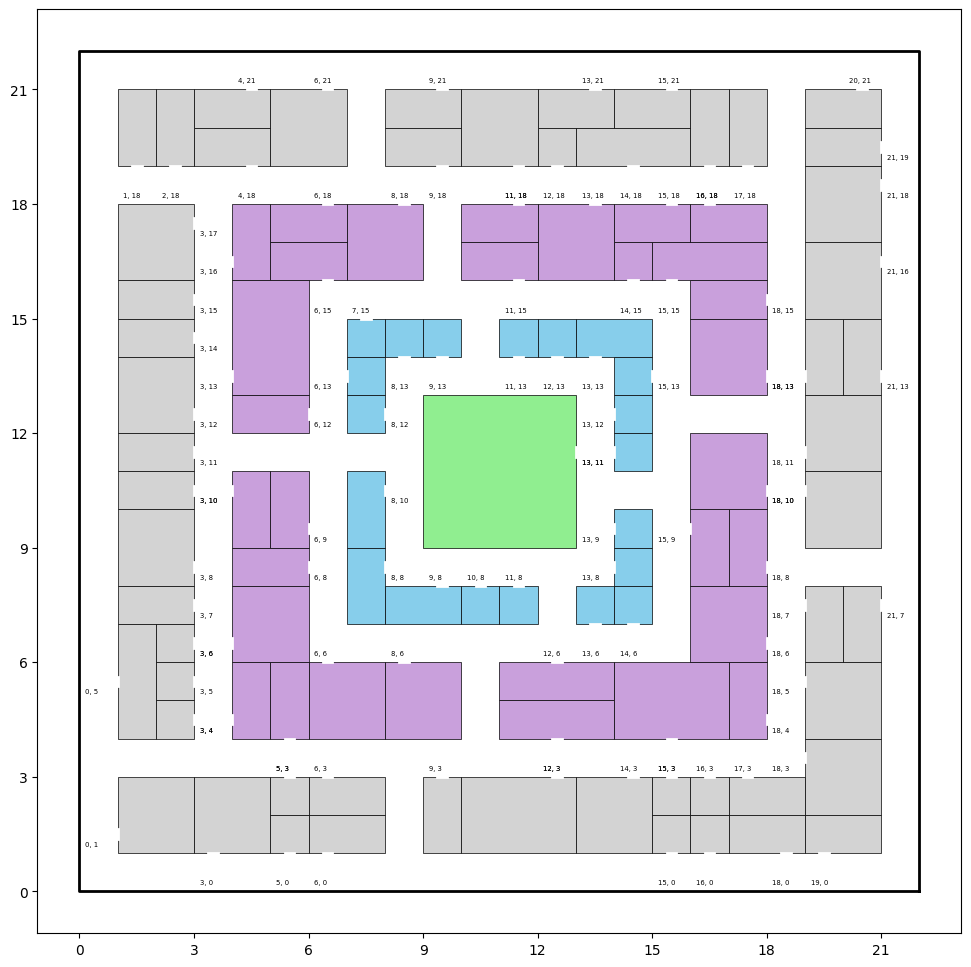

In [64]:
fig, ax = plt.subplots(figsize=(12, 12))
city.plot_city(ax, doors=True, address=True)

In [ ]:
# identify a building by its door coordinates and building type
print(city.buildings[((12, 3), 'retail')].blocks)
city.buildings[((12, 3), 'retail')].door_centroid

### Trajectory Simulation

In [6]:
import pandas as pd
import numpy.random as npr
from datetime import datetime, timedelta


def traj_stay(building, n, initial_pos=None, dt=1):
    """
    Generate an instance of two-dimensional Brownian motion constrained 
    within a building with some probability of staying still.

    The Weiner process is given by X(t) = N(0, sigma^2 * t),
    or iteratively as X(t + dt) = X(t) + N(0, sigma^2 * dt).

    Parameters
    ---------
    building: Building 
        building within which to generate trajectory.
    n: int 
        number of points to generate (initial position + n-1 steps).
    initial_pos: integer tuple
        initial position (x, y) if not building door.
    dt: float
        time step (n*dt gives the duration of the stay).

    Returns
    -------
    A numpy array of floats with shape (n,2).
    """
    bbox = building.geometry
    door = building.geometry.intersection(city.streets[building.door].geometry)
    p = building.p_still  # probability of staying still
    sigma = building.sigma  # "speed" of Brownian motion

    out = np.empty((n, 2))

    if initial_pos is not None:
        point = initial_pos
    else:
        point = ((door.coords[0][0] + door.coords[1][0]) / 2,
                 (door.coords[0][1] + door.coords[1][1]) / 2)
    out[0, :] = point
    stay_probs = np.random.binomial(1, p, n)

    for t in range(n-1):

        # move with probability 1-p
        if stay_probs[t] == 0:

            r = np.random.normal(loc=0, scale=sigma * np.sqrt(dt), size=2)
            point = out[t, :] + r

            # redraw if new point falls outside building
            while not bbox.contains(Point(point)):
                r = np.random.normal(loc=0, scale=sigma * np.sqrt(dt), size=2)
                point = out[t, :] + r

        out[t+1, :] = point

    return out


def traj_move2(city, start, end, speed=50, p=0.2):
    """
    Generate a move between two street blocks, constrained to the streets with
    some probability of stopping.

    Parameters
    ---------
    start: coordinate (x, y)
    end: coordinate (x, y)
    speed: double
        speed in meters/minute (each block is 15m by 15m)
    p: double (0 < p < 1)
        probability of staying still at any given time step

    Returns
    -------
    A numpy array of floats with shape (n, 2).
    """
    path = city.shortest_paths[start][end]
    pathml = MultiLineString([path])

    dist = pathml.length
    totaltime = dist*15/speed

    traj_raw = np.empty((int(totaltime)+1, 2))

    # passing in a vector of fractions
    for t in range(int(totaltime)+1):
        frac = dist * t/totaltime
        traj_raw[t,] = pathml.interpolate(frac).coords

    # Probability of staying still
    ps = np.random.geometric(p=1-p, size=traj_raw.shape[0])
    traj = np.vstack([coord for coord, count in zip(traj_raw, ps) for _ in range(count)])

    return traj + 0.5  # put trajectory in middle of street


def condense_destinations(destination):
    """
    Modifies a sequence of timestamped destinations, joining consecutive 
    destinations in the same location into a single entry with the aggregated duration.

    Parameters
    ----------
    destination : DataFrame
        DataFrame containing timestamped locations the user is heading towards.

    Returns
    -------
    DataFrame
        A new DataFrame with condensed destination entries.
    """
    if destination.empty:
        return pd.DataFrame()

    # Detect changes in location
    destination['new_segment'] = destination['location'].ne(destination['location'].shift())

    # Create segment identifiers for grouping
    destination['segment_id'] = destination['new_segment'].cumsum()

    # Aggregate data by segment
    condensed_df = destination.groupby('segment_id').agg({
        'unix_timestamp': 'first',
        'location': 'first',
        'duration': 'sum'
    }).reset_index(drop=True)

    return condensed_df

In [107]:
start_time = [datetime(2000, 1, 1, hour=0, minute=0) + timedelta(minutes=15*t) for t in range(22)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [15]*22  # in minutes
location = [((8, 13), 'home'),
            ((8, 13), 'home'),
            ((12, 3), 'retail'),
            ((12, 3), 'retail'),
            ((12, 3), 'retail'),
            ((12, 3), 'retail'),
            ((15, 15), 'work'),
            ((15, 15), 'work'),
            ((15, 15), 'work'),
            ((15, 15), 'work'),
            ((15, 15), 'work'),
            ((15, 15), 'work'),
            ((15, 15), 'work'),
            ((15, 15), 'work'),
            ((15, 15), 'work'),
            ((15, 15), 'work'),
            ((15, 15), 'work'),
            ((15, 15), 'work'),
            ((8, 13), 'home'),
            ((8, 13), 'home'),
            ((8, 13), 'home'),
            ((8, 13), 'home')]

destination = pd.DataFrame({"unix_timestamp":unix_timestamp, "local_timestamp":start_time, "duration":duration, "location":location})
destination = condense_destinations(destination)

# attributes of class Population with Agents (with location sequence and trajectory)
# City has attributes sigma, p (associated with each Building type), maybe larger sigma for streets if we end up doing that

Duncan = Agent("Duncan", 
               city.buildings[((8, 13), 'home')], 
               city.buildings[((15, 15), 'work')], 
               destination_diary=destination)
traj_from_dest(Duncan, city)

# print(Duncan.diary)
# print(Duncan.trajectory.to_string())
Duncan.trajectory

Seed: 35


,x,y,local_timestamp,unix_timestamp,identifier
0,8.500000,14.000000,2000-01-01 00:00:00,946684800,Duncan
1,8.500000,14.000000,2000-01-01 00:01:00,946684860,Duncan
2,8.500000,14.000000,2000-01-01 00:02:00,946684920,Duncan
3,8.500000,14.000000,2000-01-01 00:03:00,946684980,Duncan
4,8.500000,14.000000,2000-01-01 00:04:00,946685040,Duncan
...,...,...,...,...,...
326,8.046846,14.627086,2000-01-01 05:26:00,946704360,Duncan
327,8.095545,14.252296,2000-01-01 05:27:00,946704420,Duncan
328,8.604480,14.221695,2000-01-01 05:28:00,946704480,Duncan
329,8.604480,14.221695,2000-01-01 05:29:00,946704540,Duncan


In [10]:
unix_timestamp = destination['unix_timestamp'].iloc[1]
pd.to_datetime(unix_timestamp, unit='s')

Timestamp('2000-01-01 00:30:00')

In [106]:
start_time = [datetime(2000, 1, 1,hour=0, minute=0)+timedelta(minutes=15*t) for t in range(18)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [15]*18  # in minutes
location = [((13, 11), 'home'),
            ((13, 11), 'home'),
            ((13, 11), 'home'),
            ((12, 3), 'retail'),
            ((12, 3), 'retail'),
            ((12, 3), 'retail'),
            ((8, 18), 'work'),
            ((8, 18), 'work'),
            ((8, 18), 'work'),
            ((8, 18), 'work'),
            ((8, 18), 'work'),
            ((8, 18), 'work'),
            ((8, 18), 'work'),
            ((8, 18), 'work'),
            ((13, 11), 'home'),
            ((13, 11), 'home'),
            ((13, 11), 'home'),
            ((13, 11), 'home')]

destination = pd.DataFrame({"unix_timestamp":unix_timestamp, "local_timestamp":start_time, "duration":duration, "location":location})
destination = condense_destinations(destination)

Angela = Agent("Angela", 
               city.buildings[((13, 11), 'home')], 
               city.buildings[((8, 18), 'work')],
               destination_diary=destination)
traj_from_dest(Angela, city)

# Angela.diary
#print(Angela.trajectory.to_string())
Angela.trajectory

Seed: 54


,x,y,local_timestamp,unix_timestamp,identifier
0,14.000000,11.500000,2000-01-01 00:00:00,946684800,Angela
1,14.000000,11.500000,2000-01-01 00:01:00,946684860,Angela
2,14.000000,11.500000,2000-01-01 00:02:00,946684920,Angela
3,14.000000,11.500000,2000-01-01 00:03:00,946684980,Angela
4,14.000000,11.500000,2000-01-01 00:04:00,946685040,Angela
...,...,...,...,...,...
266,14.154714,11.617078,2000-01-01 04:26:00,946700760,Angela
267,14.154714,11.617078,2000-01-01 04:27:00,946700820,Angela
268,14.154714,11.617078,2000-01-01 04:28:00,946700880,Angela
269,14.026364,11.160760,2000-01-01 04:29:00,946700940,Angela


In [108]:
population = Population(city)
population.add_agent(Duncan)
population.add_agent(Angela)

population.roster

[<__main__.Agent at 0x7f4c456a0b90>, <__main__.Agent at 0x7f4c45c1ac50>]

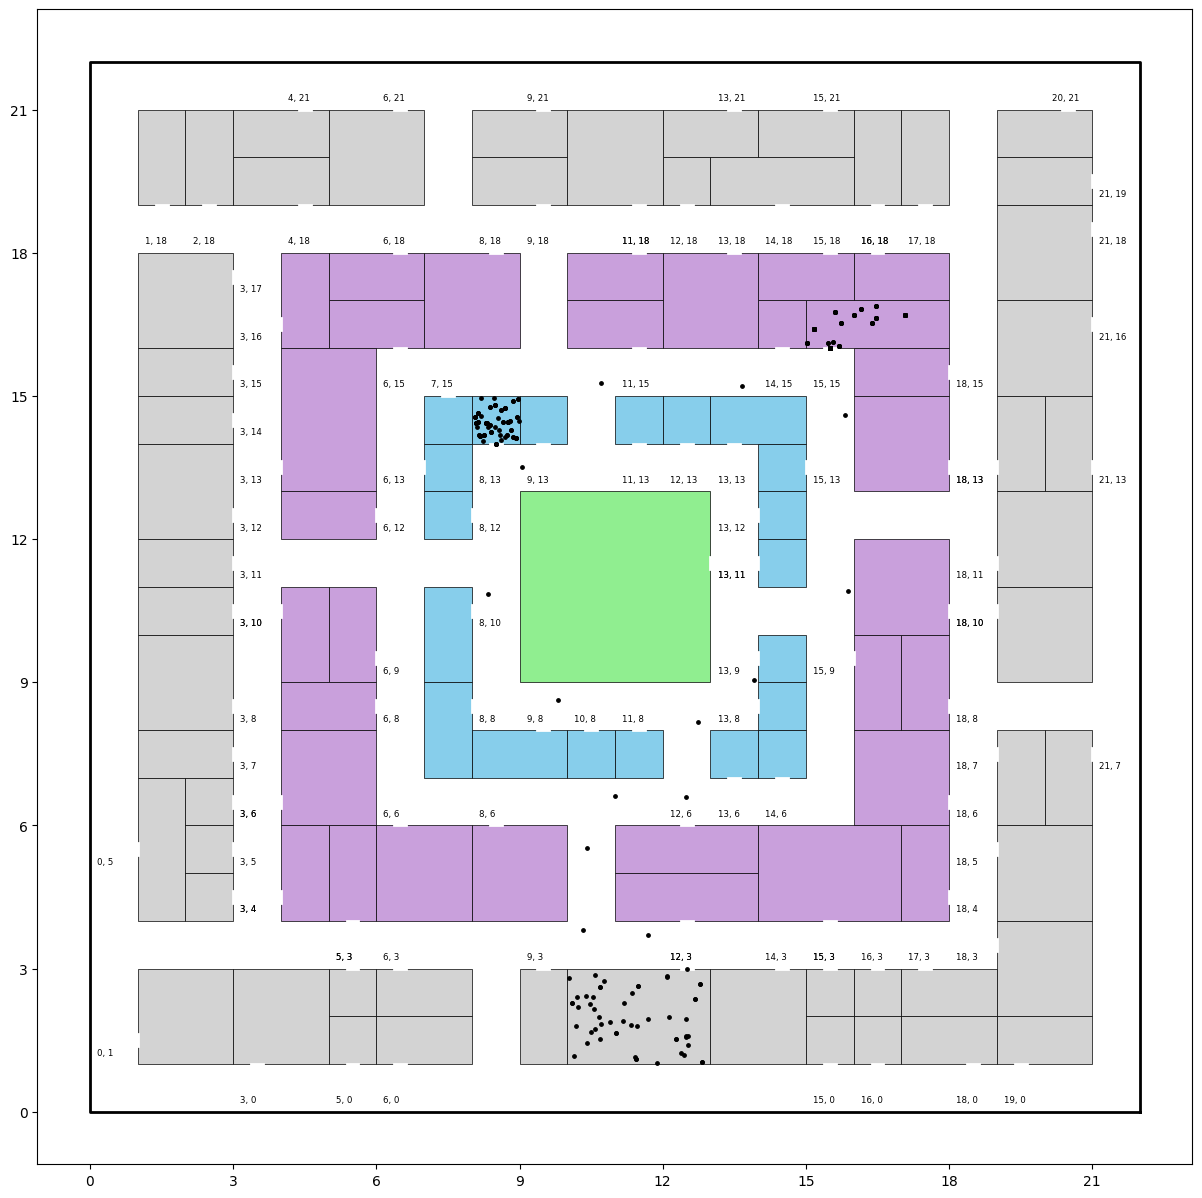

In [104]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(Duncan.trajectory.x, Duncan.trajectory.y, s=6, color='black', alpha=1, zorder=2)
city.plot_city(ax, doors=True, address=True, zorder=1)

plt.savefig("garden-city-one-user.png")

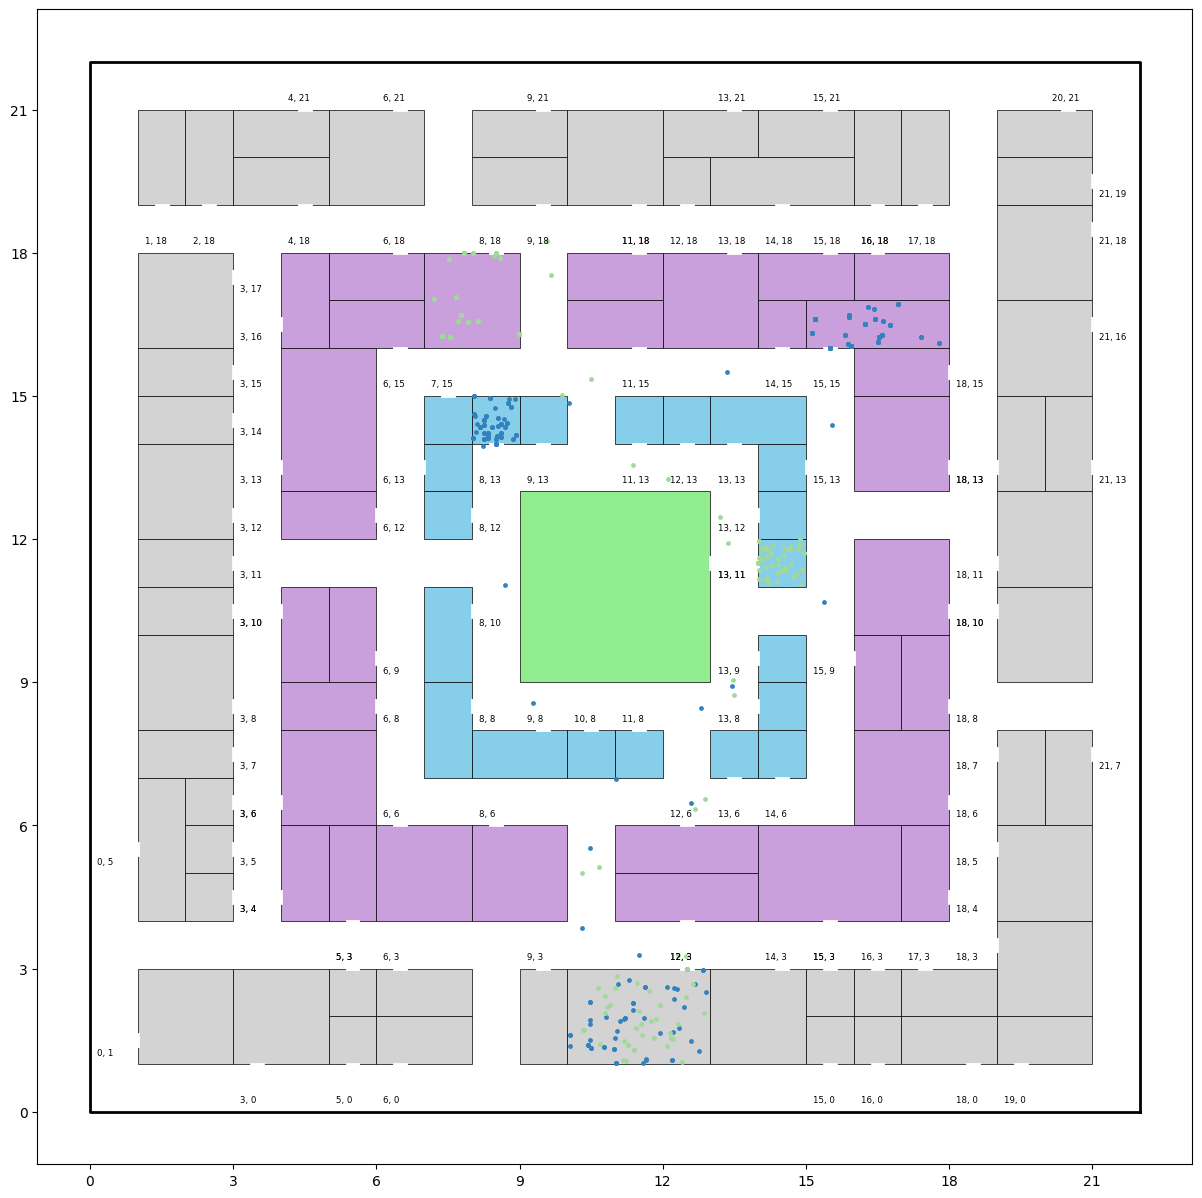

In [109]:
fig, ax = plt.subplots(figsize=(15, 15))
population.plot_population(ax)

plt.savefig("garden-city-two-users.png")

Animation of pre-sampled trajectory for one users

In [105]:
# from matplotlib.animation import FuncAnimation, PillowWriter

# fig, ax = plt.subplots(figsize=(15, 15))

# city.plot_city(ax, doors=True, address=True, zorder=1)

# line, = ax.plot([], [], color='blue', alpha=0.1)
# scatter = ax.scatter([], [], s=8, color='black', alpha=0.5)
# time_text = ax.text(0.5, 0.975, '', transform=ax.transAxes)


# def update(i):
#     line.set_data(Duncan.trajectory['x'][:i], Duncan.trajectory['y'][:i])
#     scatter.set_offsets(Duncan.trajectory[['x', 'y']][:i])
#     time_text.set_text(Duncan.trajectory['local_timestamp'][i].strftime('%Y-%m-%d %H:%M:%S'))
#     return line, scatter


# anim = FuncAnimation(fig, update, frames=len(Duncan.trajectory), interval=50, blit=True)
# anim.save('garden-city-traj-animation.gif', writer=PillowWriter(fps=20))
# plt.close(fig)